## ENDG 511 Final Project ##
*Topic: Real-time Clothing Classification System for the Visually Impaired and Laundry Automation*

*Authors: Jarrel Gumpal (30069206) and Fayez Khan ()*

**SCROLL TO LAST CELL FOR FINAL CODE (RUN)**

Table of Contents:
1. Base Model
2. EfficientNet80 (Selected)
3. MobileNetV2
4. ResNet50
5. Performance Metrics
6. Compression Methods
    - Pruning
    - Quantization
7. Final Code used for Demonstration

## Raw Dataset Example ##

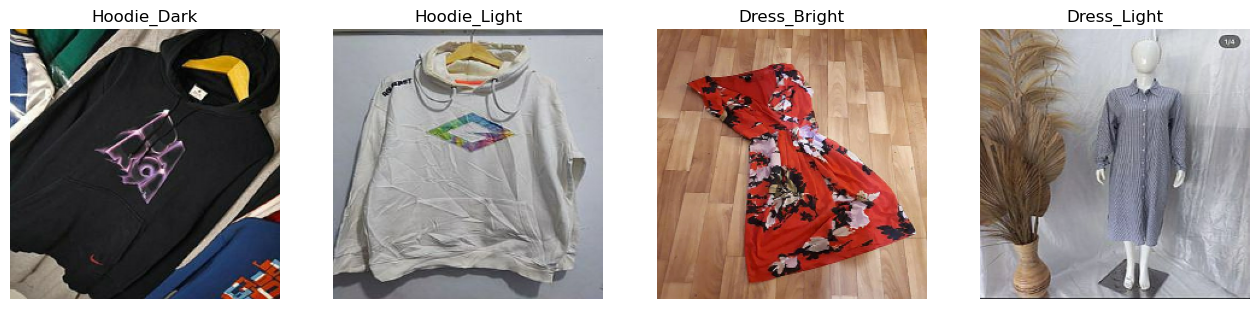

In [34]:
import matplotlib.pyplot as plt

# Pull one batch from the raw dataset (unaugmented, unnormalized)
for images, labels in raw_train_dataset.take(1):
    plt.figure(figsize=(16, 4))  # 4x1 layout

    for i in range(4):
        ax = plt.subplot(1, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    break


Found 3694 files belonging to 24 classes.
Using 2956 files for training.
Found 3694 files belonging to 24 classes.
Using 738 files for validation.
Epoch 1/20


c:\Users\Jarrel\anaconda3\envs\endg511\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 849ms/step - accuracy: 0.0874 - loss: 3.2985 - val_accuracy: 0.2615 - val_loss: 2.5302
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 857ms/step - accuracy: 0.2225 - loss: 2.6111 - val_accuracy: 0.3808 - val_loss: 2.0550
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 856ms/step - accuracy: 0.3503 - loss: 2.1228 - val_accuracy: 0.4309 - val_loss: 1.8097
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 858ms/step - accuracy: 0.4156 - loss: 1.8673 - val_accuracy: 0.4729 - val_loss: 1.7022
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 857ms/step - accuracy: 0.5167 - loss: 1.5521 - val_accuracy: 0.4770 - val_loss: 1.6583
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 856ms/step - accuracy: 0.5579 - loss: 1.3598 - val_accuracy: 0.4905 - val_loss: 1.6653
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 874ms/step - accuracy: 0.6248 - loss: 1.1643 - val_accuracy: 0.4892 - val_loss: 1.6640
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 866ms/step - accuracy: 0.6732 - loss: 1.0150 - val_accuracy: 0.510


✅ Validation Accuracy: 55.15%
✅ Model size: 127.90 MB

⏱ Measuring average inference time on 32 images...
✅ Average inference time per image: 5.45 ms


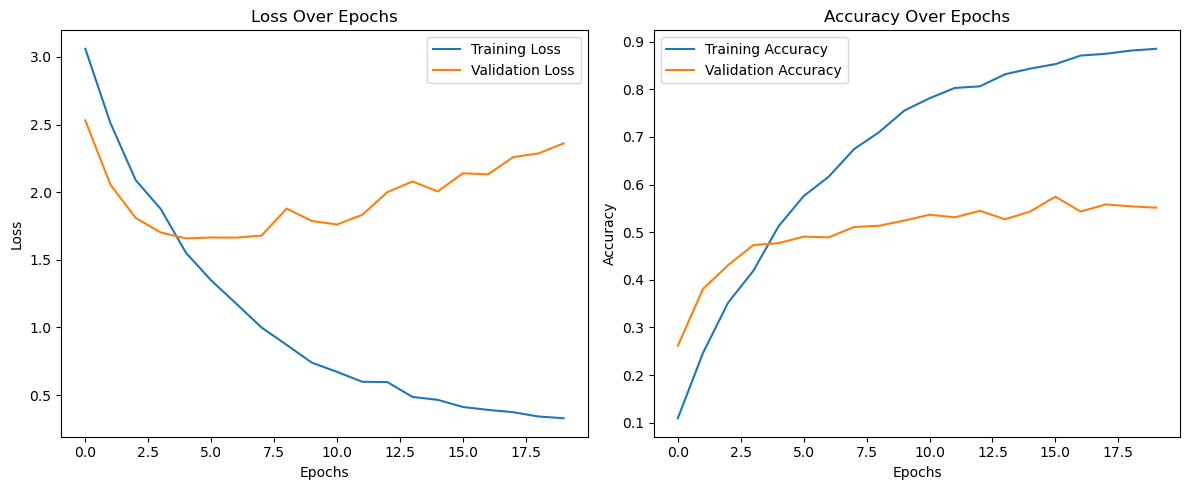

In [42]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import time
import numpy as np

# Dataset path
data_dir = r'C:\Users\Jarrel\Desktop\offrun'

# Parameters
img_size = (224, 224)
batch_size = 64

# Load dataset (no augmentation)
raw_train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
raw_val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Class labels
class_names = raw_train_dataset.class_names
num_classes = len(class_names)

# Normalize: scale pixel values 0–255 → 0–1
normalization_layer = layers.Rescaling(1./255)
train_dataset = raw_train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = raw_val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

# ✅ Custom CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train
epochs = 20
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

# =======================
# ✅ Evaluation & Metrics
# =======================
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"\n✅ Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save model & size
model_path = "cnn_scratch_model.h5"
model.save(model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"✅ Model size: {model_size:.2f} MB")

# Inference time test
print("\n⏱ Measuring average inference time on 32 images...")
inference_images = []
for images, _ in val_dataset.unbatch().take(32):
    inference_images.append(images)
inference_images = tf.stack(inference_images)

_ = model.predict(inference_images[:1], verbose=0)  # Warm-up
start_time = time.time()
_ = model.predict(inference_images, verbose=0)
end_time = time.time()
avg_inference_time = (end_time - start_time) / len(inference_images)
print(f"✅ Average inference time per image: {avg_inference_time * 1000:.2f} ms")

# =======================
# 📊 Plot Training Graphs
# =======================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()



## ResNet50 Attempt

Found 3694 files belonging to 24 classes.
Using 2956 files for training.
Found 3694 files belonging to 24 classes.
Using 738 files for validation.
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.2418 - loss: 3.3070 - val_accuracy: 0.5339 - val_loss: 1.9130
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.5069 - loss: 2.0322 - val_accuracy: 0.6043 - val_loss: 1.6508
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5786 - loss: 1.7544 - val_accuracy: 0.6491 - val_loss: 1.5153
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6184 - loss: 1.5485 - val_accuracy: 0.6734 - val_loss: 1.3821
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6697 - loss: 1.3911 - val_accuracy: 0.6829 - val_loss: 1.3431
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6550 - loss: 1.3272 - val_accuracy: 0.6707 - val_loss: 1.3349
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6838 - loss: 1.2534 - val_

Validation Accuracy after fine-tuning: 0.7331
Model size: 220983920 bytes (210.75 MB)


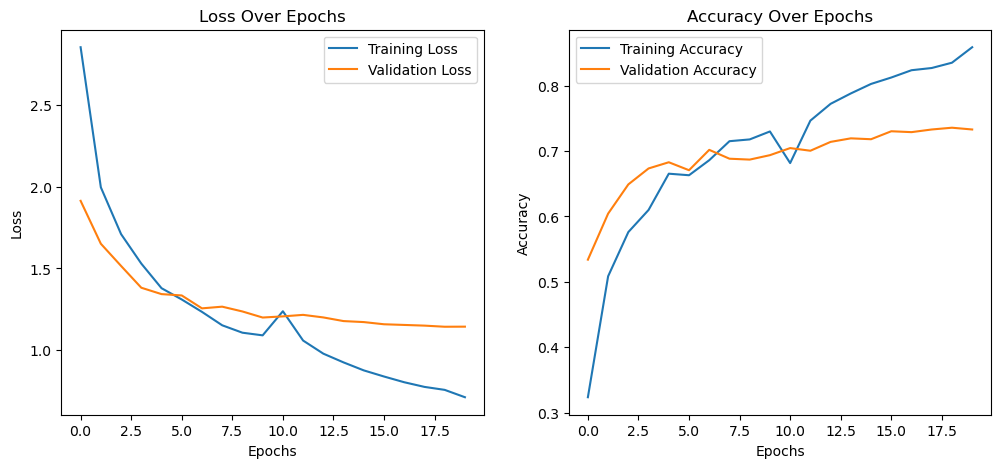

12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7323 - loss: 1.1222



 Validation Accuracy: 73.31%
Model size: 210.75 MB

⏱ Measuring average inference time on 32 images...
 Average inference time per image: 76.27 ms


In [36]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os

# Define dataset directory
data_dir = r'C:\Users\Jarrel\Desktop\offrun'

# Set batch size and image size
batch_size = 64
img_size = (224, 224)

# Load dataset with an 80/20 split
raw_train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
raw_val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Get class names
class_names = raw_train_dataset.class_names
num_classes = len(class_names)

# Import correct ResNet preprocessing
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.Lambda(lambda x: tf.image.adjust_brightness(x, delta=0.3))  # Increase brightness
])

# Use preprocess_input for ResNet
normalization_layer = layers.Lambda(preprocess_input)

# Apply augmentation and normalization
train_dataset = raw_train_dataset.map(
    lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y)
)
val_dataset = raw_val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetching for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Load ResNet50 base model
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model (initial phase)
initial_epochs = 10
history_initial = model.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs)

# Unfreeze some of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = 140  # Freeze early layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile again with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune model
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_finetune = model.fit(train_dataset, validation_data=val_dataset,
                             epochs=total_epochs, initial_epoch=history_initial.epoch[-1] + 1)

# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy after fine-tuning: {val_accuracy:.4f}")

# Save model
model_path = "resnet50_finetuned_model.h5"
model.save(model_path)
model_size = os.path.getsize(model_path)
print(f"Model size: {model_size} bytes ({model_size / (1024*1024):.2f} MB)")

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['loss'] + history_finetune.history['loss'], label='Training Loss')
plt.plot(history_initial.history['val_loss'] + history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_initial.history['accuracy'] + history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()
import time
import numpy as np
import os

#  Evaluate accuracy on validation dataset
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"\n Validation Accuracy: {val_accuracy * 100:.2f}%")

#  Save and report model size
model_path = "resnet50_finetuned_model.h5"
model.save(model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)  # in MB
print(f"Model size: {model_size:.2f} MB")

# Measure inference time on a small batch
print("\n⏱ Measuring average inference time on 32 images...")
inference_images = []
for images, _ in val_dataset.unbatch().take(32):
    inference_images.append(images)
inference_images = tf.stack(inference_images)

# Warm-up run
_ = model.predict(inference_images[:1], verbose=0)

# Timed run
start_time = time.time()
_ = model.predict(inference_images, verbose=0)
end_time = time.time()

avg_inference_time = (end_time - start_time) / len(inference_images)
print(f" Average inference time per image: {avg_inference_time * 1000:.2f} ms")



<Figure size 1000x800 with 0 Axes>

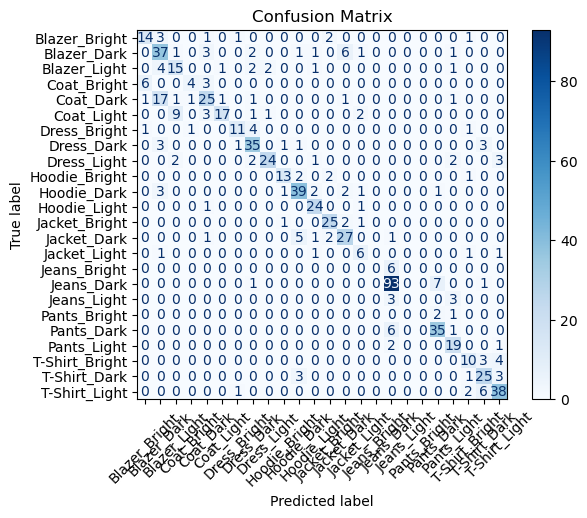

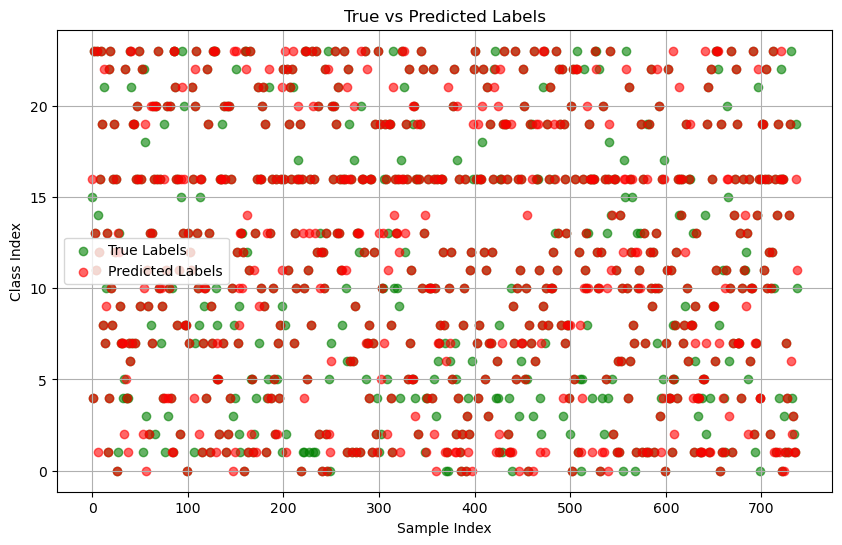

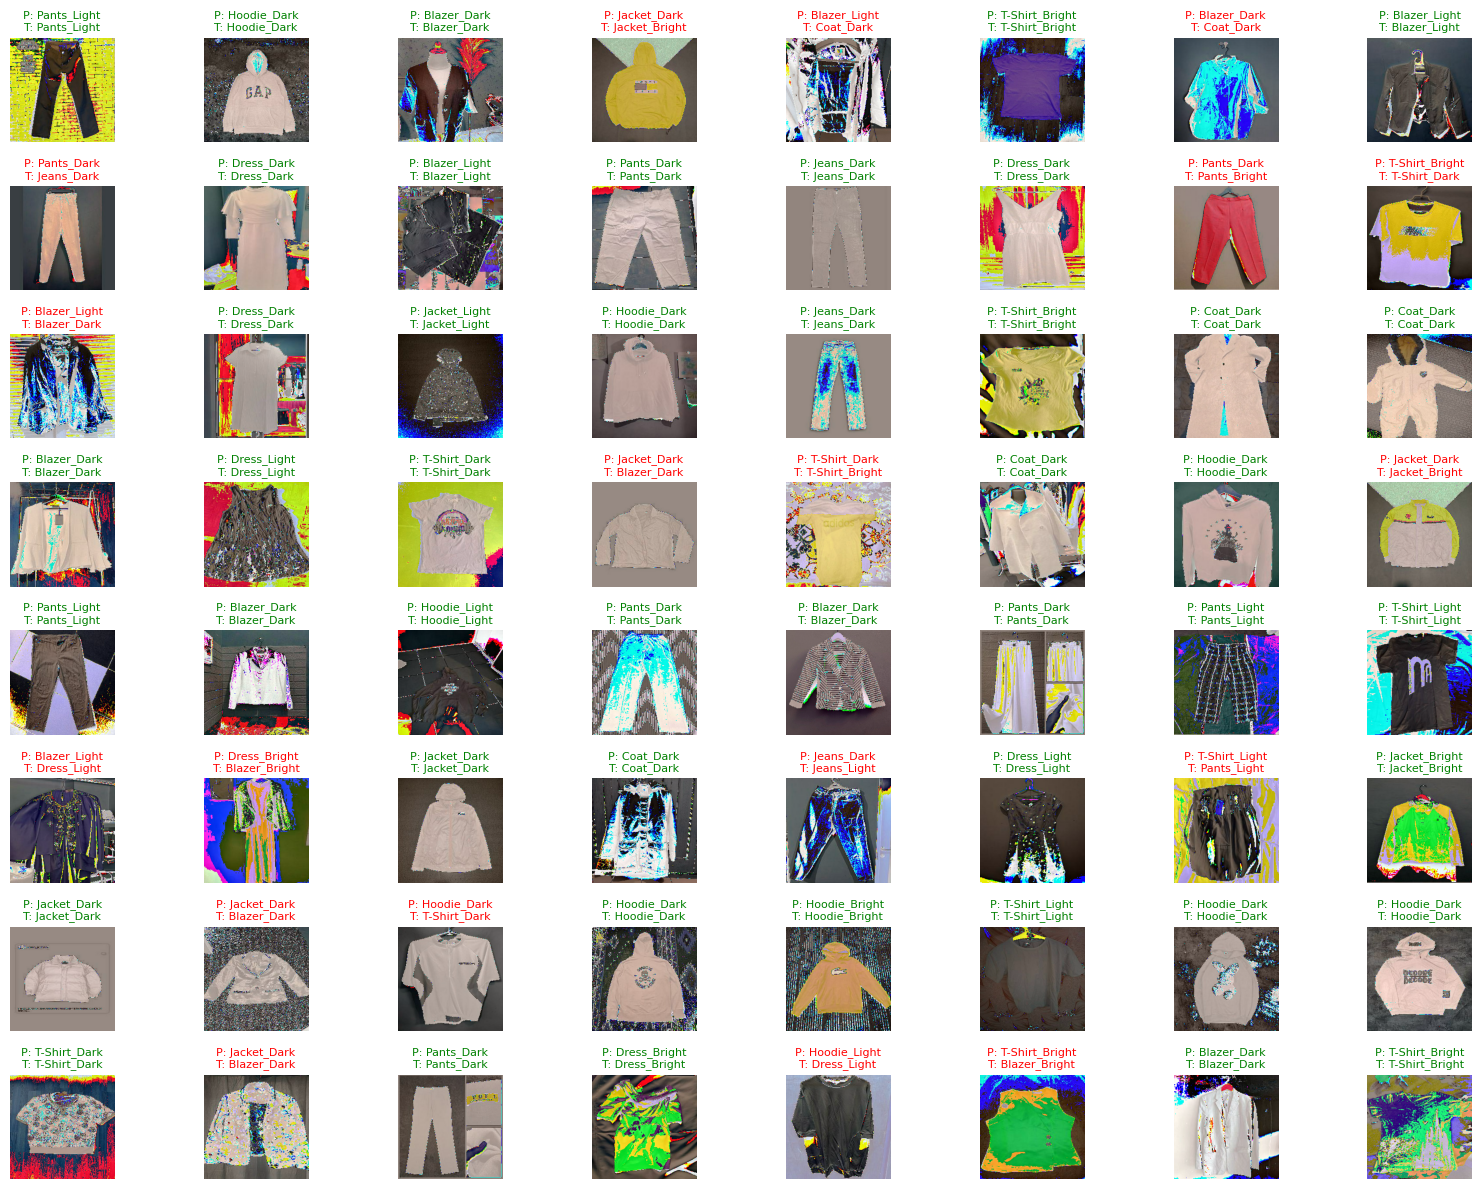

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Get predictions and labels
y_true = []
y_pred = []

for images, labels in val_dataset.unbatch():
    img_array = tf.expand_dims(images, axis=0)
    predictions = model.predict(img_array, verbose=0)
    predicted_class = tf.argmax(predictions[0])
    
    y_true.append(int(labels.numpy()))
    y_pred.append(int(predicted_class.numpy()))
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot it
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
# Simple scatter plot of predictions vs ground truth
plt.figure(figsize=(10, 6))
plt.scatter(range(len(y_true)), y_true, c='green', label='True Labels', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, c='red', label='Predicted Labels', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Class Index')
plt.title('True vs Predicted Labels')
plt.legend()
plt.grid(True)
plt.show()
# Get predictions and images from the validation dataset
y_true = []
y_pred = []
images_to_plot = []
predicted_labels = []

for image, label in val_dataset.unbatch().take(64):  # Adjust number if needed
    img_array = tf.expand_dims(image, axis=0)
    prediction = model.predict(img_array, verbose=0)
    predicted_class = tf.argmax(prediction[0])

    y_true.append(int(label.numpy()))
    y_pred.append(int(predicted_class.numpy()))
    images_to_plot.append(image.numpy())
    predicted_labels.append(predicted_class.numpy())

# Plot a matrix/grid of images with predicted and true labels
plt.figure(figsize=(16, 12))
for i in range(len(images_to_plot)):
    plt.subplot(8, 8, i + 1)  # Adjust grid size (e.g., 8x8 for 64 images)
    plt.imshow(images_to_plot[i].astype("uint8"))
    true_label = class_names[y_true[i]]
    pred_label = class_names[y_pred[i]]
    color = 'green' if y_true[i] == y_pred[i] else 'red'
    plt.title(f"P: {pred_label}\nT: {true_label}", fontsize=8, color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()

## EfficientNetB0 ##

Found 3694 files belonging to 24 classes.
Using 2956 files for training.
Found 3694 files belonging to 24 classes.
Using 738 files for validation.
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.2709 - loss: 2.9558 - val_accuracy: 0.5434 - val_loss: 1.8421
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.5739 - loss: 1.7975 - val_accuracy: 0.6233 - val_loss: 1.5411
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6194 - loss: 1.5354 - val_accuracy: 0.6477 - val_loss: 1.4227
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.6810 - loss: 1.3629 - val_accuracy: 0.6667 - val_loss: 1.3520
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6803 - loss: 1.3213 - val_accuracy: 0.6762 - val_loss: 1.3095
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7115 - loss: 1.2184 - val_accuracy: 0.6924 - val_loss: 1.2561
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.7428 - loss: 1.1285 - val_accurac


✅ Validation Accuracy: 69.38%
✅ Model size: 49.13 MB

⏱ Measuring average inference time on 32 images...


✅ Average inference time per image: 54.04 ms


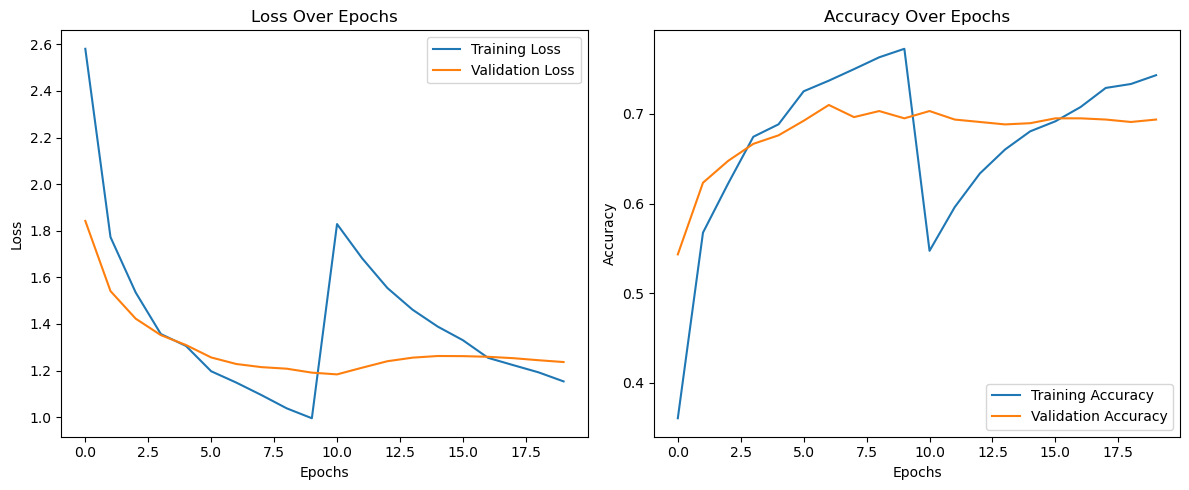

In [40]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import time
import numpy as np

# Dataset directory
data_dir = r'C:\Users\Jarrel\Desktop\offrun'

# Image and batch size
batch_size = 64
img_size = (224, 224)

# Load original dataset (no augmentation here)
raw_train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
raw_val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Class info
class_names = raw_train_dataset.class_names
num_classes = len(class_names)

# Use EfficientNet preprocessing
from tensorflow.keras.applications.efficientnet import preprocess_input

# Augmentation + brightness
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.Lambda(lambda x: tf.image.adjust_brightness(x, delta=0.3))  # Brighten image
])

# Normalization for EfficientNet
normalization_layer = layers.Lambda(preprocess_input)

# Apply transformations
train_dataset = raw_train_dataset.map(
    lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y)
)
val_dataset = raw_val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

# Load EfficientNetB0 base
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze base

# Build final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile and train initial phase
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10
history_initial = model.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs)

# Fine-tune deeper layers
base_model.trainable = True
fine_tune_at = 100  # freeze first 100 layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_finetune = model.fit(train_dataset, validation_data=val_dataset,
                             epochs=total_epochs, initial_epoch=history_initial.epoch[-1] + 1)

# ===========================
# ✅ Evaluation & Reporting
# ===========================

# Evaluate accuracy
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"\n✅ Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save model and show size
model_path = "efficientnet_finetuned_model.h5"
model.save(model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"✅ Model size: {model_size:.2f} MB")

# Measure inference time
print("\n⏱ Measuring average inference time on 32 images...")
inference_images = []
for images, _ in val_dataset.unbatch().take(32):
    inference_images.append(images)
inference_images = tf.stack(inference_images)

# Warm-up
_ = model.predict(inference_images[:1], verbose=0)

# Timed run
start_time = time.time()
_ = model.predict(inference_images, verbose=0)
end_time = time.time()

avg_inference_time = (end_time - start_time) / len(inference_images)
print(f"✅ Average inference time per image: {avg_inference_time * 1000:.2f} ms")

# ===========================
# 📊 Plot Training Results
# ===========================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['loss'] + history_finetune.history['loss'], label='Training Loss')
plt.plot(history_initial.history['val_loss'] + history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_initial.history['accuracy'] + history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


## MobileNetV2 ##

Found 3694 files belonging to 24 classes.
Using 2956 files for training.
Found 3694 files belonging to 24 classes.
Using 738 files for validation.
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 46s 906ms/step - accuracy: 0.2584 - loss: 3.0830 - val_accuracy: 0.5271 - val_loss: 1.9674
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 885ms/step - accuracy: 0.5136 - loss: 1.9715 - val_accuracy: 0.5962 - val_loss: 1.6575
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 883ms/step - accuracy: 0.5672 - loss: 1.7090 - val_accuracy: 0.6057 - val_loss: 1.5493
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 885ms/step - accuracy: 0.6099 - loss: 1.5819 - val_accuracy: 0.6287 - val_loss: 1.4451
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 886ms/step - accuracy: 0.6364 - loss: 1.4895 - val_accuracy: 0.6504 - val_loss: 1.3788
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 882ms/step - accuracy: 0.6601 - loss: 1.3696 - val_accuracy: 0.6667 - val_loss: 1.3276
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 42s 888ms/step - accuracy: 0.6703 - loss:


✅ Validation Accuracy: 67.07%
✅ Model size: 27.04 MB

⏱ Measuring average inference time on 32 images...
✅ Average inference time per image: 33.04 ms


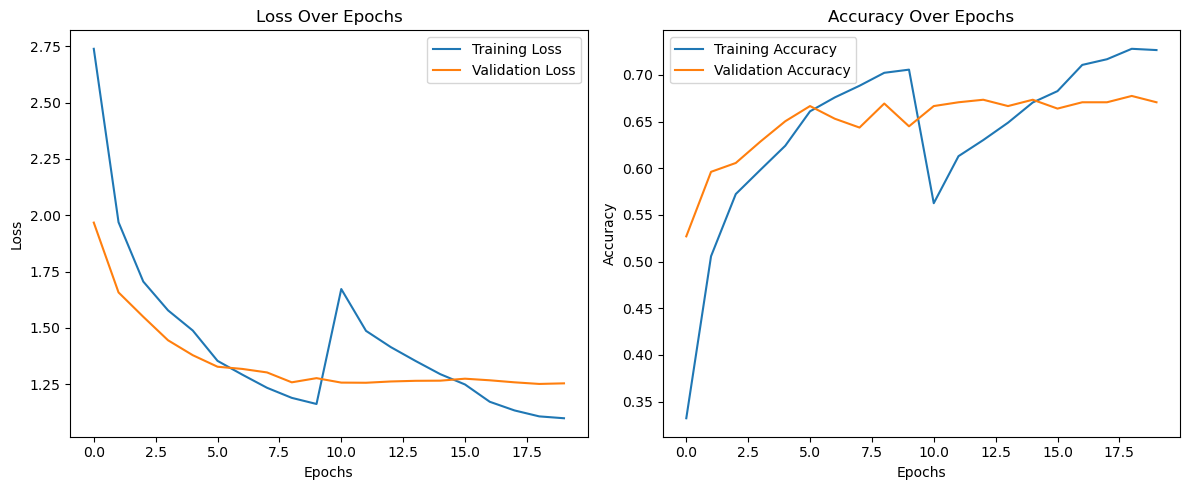

In [41]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import time
import numpy as np

# Dataset directory
data_dir = r'C:\Users\Jarrel\Desktop\offrun'

# Image and batch size
batch_size = 64
img_size = (224, 224)

# Load original dataset
raw_train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)
raw_val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Class info
class_names = raw_train_dataset.class_names
num_classes = len(class_names)

# Import MobileNetV2 preprocessing
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.Lambda(lambda x: tf.image.adjust_brightness(x, delta=0.3))
])

# Normalization
normalization_layer = layers.Lambda(preprocess_input)

# Apply transformations
train_dataset = raw_train_dataset.map(
    lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y)
)
val_dataset = raw_val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Prefetching
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

# Load MobileNetV2 base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

# Build final model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile and train (initial phase)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

initial_epochs = 10
history_initial = model.fit(train_dataset, validation_data=val_dataset, epochs=initial_epochs)

# Unfreeze deeper layers for fine-tuning
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning phase
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history_finetune = model.fit(train_dataset, validation_data=val_dataset,
                             epochs=total_epochs, initial_epoch=history_initial.epoch[-1] + 1)

# ===========================
# ✅ Evaluation & Reporting
# ===========================

# Evaluate accuracy
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"\n✅ Validation Accuracy: {val_accuracy * 100:.2f}%")

# Save model and report size
model_path = "mobilenetv2_finetuned_model.h5"
model.save(model_path)
model_size = os.path.getsize(model_path) / (1024 * 1024)
print(f"✅ Model size: {model_size:.2f} MB")

# Inference time test
print("\n⏱ Measuring average inference time on 32 images...")
inference_images = []
for images, _ in val_dataset.unbatch().take(32):
    inference_images.append(images)
inference_images = tf.stack(inference_images)

# Warm-up
_ = model.predict(inference_images[:1], verbose=0)

# Time inference
start_time = time.time()
_ = model.predict(inference_images, verbose=0)
end_time = time.time()

avg_inference_time = (end_time - start_time) / len(inference_images)
print(f"✅ Average inference time per image: {avg_inference_time * 1000:.2f} ms")

# ===========================
# 📊 Plot Training Results
# ===========================
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_initial.history['loss'] + history_finetune.history['loss'], label='Training Loss')
plt.plot(history_initial.history['val_loss'] + history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_initial.history['accuracy'] + history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


Pruning:

In [14]:
!pip install -q tensorflow==2.18.0

In [ ]:
import tempfile
import os
import time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_model_optimization as tfmot

In [13]:
model_to_quantize = tf.keras.models.load_model('mobilenetv2_finetuned_model.h5')
model_to_quantize.summary()
# Passing the Keras model to the TFLite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
# Setting the deault optimizer
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# To convert to 16-bit floating point for example
# converter.target_spec.supported_types = [tf.float16]
# Convert the model
quantized_tflite_model = converter.convert()

RecursionError: maximum recursion depth exceeded in comparison

## DEMO CODE ##

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import pyttsx3
import time

# Load your trained model (ensure the model file is in the working directory)
model = tf.keras.models.load_model("mobilenetv2_finetuned_model.h5")
# Initialize the TTS engine
engine = pyttsx3.init()
voices = engine.getProperty('voices')
# Set the text you want to speak
engine.setProperty('voice', voices[1].id)

# Optionally, change the speaking rate (words per minute)
engine.setProperty('rate', 150)
text = "Initializing..."

# Speak the text
engine.say(text)

# Wait until the speaking is finished

# Define your class names (should be in the same order as during training)
class_names = ['Blazer_Bright', 'Blazer_Dark', 'Blazer_Light', 'Coat_Bright', 'Coat_Dark', 'Coat_Light', 'Dress_Bright', 'Dress_Dark', 'Dress_Light', 'Hoodie_Bright', 'Hoodie_Dark', 'Hoodie_Light', 'Jacket_Bright', 'Jacket_Dark', 'Jacket_Light', 'Jeans_Bright', 'Jeans_Dark', 'Jeans_Light', 'Pants_Bright', 'Pants_Dark', 'Pants_Light', 'T-Shirt_Bright', 'T-Shirt_Dark', 'T-Shirt_Light']

# Initialize webcam (0 is typically the default webcam)
cap = cv2.VideoCapture(0)

# Variables to control classification frequency
last_prediction_time = time.time()
prediction_interval = 8  # seconds
pred_label = "Waiting..."
pred_confidence = 0.0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    current_time = time.time()
    
    # Perform classification every 8 seconds
    if current_time - last_prediction_time >= prediction_interval:
        # Preprocess the frame:
        # Convert from BGR to RGB, resize, normalize, and add batch dimension
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        img = cv2.resize(frame_rgb, (224, 224))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Make prediction
        preds = model.predict(img)
        pred_index = np.argmax(preds, axis=1)[0]
        pred_label = class_names[pred_index]
        pred_confidence = preds[0][pred_index]
        last_prediction_time = current_time
        print(pred_label)
        temp = pred_label.split("_")
        text_call = "I am seeing a " + temp[1] + " shaded " + temp[0] + "... Place it in the " + temp[1] + " Batch"
        #engine.say(text_call)
        #engine.runAndWait()

    # Overlay prediction on the frame
    label = f"{pred_label} ({pred_confidence:.2f})"
    cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1, (0, 255, 0), 2, cv2.LINE_AA)

    # Display the frame with the overlay
    cv2.imshow("Webcam - Real-Time Classification", frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
cap.release()
cv2.destroyAllWindows()

c:\Users\Jarrel\anaconda3\envs\endg511\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
T-Shirt_Light
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
T-Shirt_Light
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Dress_Dark
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Dress_Dark


ResNet50 Model

Found 3703 files belonging to 24 classes.
Using 2963 files for training.
Found 3703 files belonging to 24 classes.
Using 740 files for validation.
Classes found: ['Blazer_Bright', 'Blazer_Dark', 'Blazer_Light', 'Coat_Bright', 'Coat_Dark', 'Coat_Light', 'Dress_Bright', 'Dress_Dark', 'Dress_Light', 'Hoodie_Bright', 'Hoodie_Dark', 'Hoodie_Light', 'Jacket_Bright', 'Jacket_Dark', 'Jacket_Light', 'Jeans_Bright', 'Jeans_Dark', 'Jeans_Light', 'Pants_Bright', 'Pants_Dark', 'Pants_Light', 'T-Shirt_Bright', 'T-Shirt_Dark', 'T-Shirt_Light']


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_6      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,853,080 (90.99 MB)

 Trainable params: 265,368 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.0810 - loss: 3.1411 - val_accuracy: 0.1446 - val_loss: 2.9489
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.1212 - loss: 2.9657 - val_accuracy: 0.1676 - val_loss: 2.9029
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.1324 - loss: 2.9202 - val_accuracy: 0.1635 - val_loss: 2.8508
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.1414 - loss: 2.8861 - val_accuracy: 0.1892 - val_loss: 2.8053
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.1561 - loss: 2.8347 - val_accuracy: 0.1973 - val_loss: 2.7644
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.1684 - loss: 2.8199 - val_accuracy: 0.2027 - val_loss: 2.7193
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.1802 - loss: 2.7974 - val_accuracy: 0.2095 - val_loss: 2.7199
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.1876 - loss: 2.7744 - val_accuracy: 0.2230 - va

Validation Accuracy: 0.2311
Model size: 97938544 bytes (93.40 MB)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


Inference time for one batch of 32 images: 1.9254 seconds
Average inference time per image: 0.0602 seconds


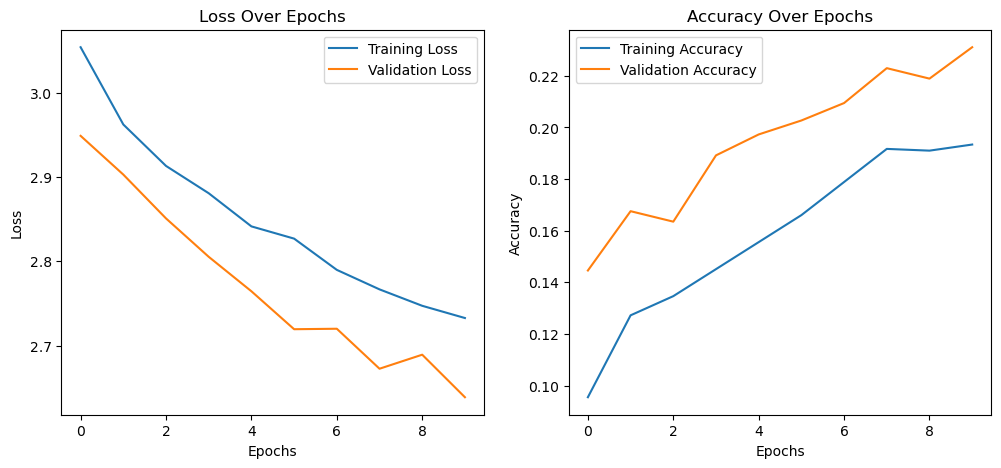

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# Define dataset directory (using a raw string for Windows paths)
data_dir = r'C:\Users\Jarrel\Desktop\offrun'

# Set batch size and image size
batch_size = 32
img_size = (224, 224)

# Load dataset with an 80/20 split
raw_train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Retrieve class names and number of classes
class_names = raw_train_dataset.class_names
num_classes = len(class_names)
print("Classes found:", class_names)

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Define normalization layer
normalization_layer = layers.Rescaling(1.0/255)

# Apply augmentation and normalization to the training dataset
train_dataset = raw_train_dataset.map(
    lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y)
)
# Apply normalization only to the validation dataset
val_dataset = raw_val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Load the ResNet50 model with pretrained ImageNet weights (exclude the top layers)
base_model = tf.keras.applications.ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model for initial training

# Create the final model by stacking custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model architecture
model.summary()

# Train the model
epochs = 10
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Save the model and print its file size
model_path = "mobilenetv2_model.h5"
model.save(model_path)
model_size = os.path.getsize(model_path)
print(f"Model size: {model_size} bytes ({model_size / (1024*1024):.2f} MB)")

# Measure inference time on one batch from the validation set
sample_images, _ = next(iter(val_dataset))
start_time = time.time()
_ = model.predict(sample_images)
end_time = time.time()
inference_time = end_time - start_time
avg_inference_time = inference_time / sample_images.shape[0]
print(f"Inference time for one batch of {sample_images.shape[0]} images: {inference_time:.4f} seconds")
print(f"Average inference time per image: {avg_inference_time:.4f} seconds")
# Print Model Metrics

# Save the model and print its file size
model_path = "mobilenetv2_model.h5"
model.save(model_path)
model_size = os.path.getsize(model_path)
#print(f"Model size: {model_size} bytes ({model_size / (1024*1024):.2f} MB)")
# Plot Training Results
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


## MobileNetV2 with Fine-tuning (Data Augmentation, Freezing, Lower Learning Rates)

Found 3703 files belonging to 24 classes.
Using 2963 files for training.
Found 3703 files belonging to 24 classes.
Using 740 files for validation.
Classes found: ['Blazer_Bright', 'Blazer_Dark', 'Blazer_Light', 'Coat_Bright', 'Coat_Dark', 'Coat_Light', 'Dress_Bright', 'Dress_Dark', 'Dress_Light', 'Hoodie_Bright', 'Hoodie_Dark', 'Hoodie_Light', 'Jacket_Bright', 'Jacket_Dark', 'Jacket_Light', 'Jeans_Bright', 'Jeans_Dark', 'Jeans_Light', 'Pants_Bright', 'Pants_Dark', 'Pants_Light', 'T-Shirt_Bright', 'T-Shirt_Dark', 'T-Shirt_Light']
Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.2362 - loss: 2.7376
Epoch 1: val_loss improved from inf to 1.60794, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 41s 411ms/step - accuracy: 0.2371 - loss: 2.7334 - val_accuracy: 0.4892 - val_loss: 1.6079
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.4517 - loss: 1.7354
Epoch 2: val_loss improved from 1.60794 to 1.35283, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - accuracy: 0.4519 - loss: 1.7349 - val_accuracy: 0.5432 - val_loss: 1.3528
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5375 - loss: 1.4557
Epoch 3: val_loss improved from 1.35283 to 1.26654, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 405ms/step - accuracy: 0.5375 - loss: 1.4556 - val_accuracy: 0.5608 - val_loss: 1.2665
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.5435 - loss: 1.3956
Epoch 4: val_loss improved from 1.26654 to 1.15245, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 405ms/step - accuracy: 0.5434 - loss: 1.3954 - val_accuracy: 0.6162 - val_loss: 1.1525
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5791 - loss: 1.3088
Epoch 5: val_loss improved from 1.15245 to 1.14443, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 407ms/step - accuracy: 0.5791 - loss: 1.3085 - val_accuracy: 0.6041 - val_loss: 1.1444
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6103 - loss: 1.1764
Epoch 6: val_loss improved from 1.14443 to 1.11384, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 406ms/step - accuracy: 0.6102 - loss: 1.1767 - val_accuracy: 0.6176 - val_loss: 1.1138
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6112 - loss: 1.2090
Epoch 7: val_loss improved from 1.11384 to 1.10276, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 404ms/step - accuracy: 0.6113 - loss: 1.2086 - val_accuracy: 0.6243 - val_loss: 1.1028
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6273 - loss: 1.1794
Epoch 8: val_loss did not improve from 1.10276
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 402ms/step - accuracy: 0.6274 - loss: 1.1788 - val_accuracy: 0.6027 - val_loss: 1.1644
Epoch 9/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.6392 - loss: 1.0948
Epoch 9: val_loss did not improve from 1.10276
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 401ms/step - accuracy: 0.6392 - loss: 1.0947 - val_accuracy: 0.6081 - val_loss: 1.1314
Epoch 10/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6457 - loss: 1.0757
Epoch 10: val_loss improved from 1.10276 to 1.09736, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 405ms/step - accuracy: 0.6458 - loss: 1.0752 - val_accuracy: 0.6122 - val_loss: 1.0974
Epoch 11/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6512 - loss: 1.0414
Epoch 11: val_loss did not improve from 1.09736
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 406ms/step - accuracy: 0.6513 - loss: 1.0411 - val_accuracy: 0.6095 - val_loss: 1.1097
Epoch 12/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.6359 - loss: 1.0893
Epoch 12: val_loss improved from 1.09736 to 1.06922, saving model to best_model.h5


93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 404ms/step - accuracy: 0.6360 - loss: 1.0886 - val_accuracy: 0.6216 - val_loss: 1.0692
Epoch 13/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6770 - loss: 0.9944
Epoch 13: val_loss did not improve from 1.06922
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 404ms/step - accuracy: 0.6770 - loss: 0.9941 - val_accuracy: 0.6135 - val_loss: 1.1348
Epoch 14/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6744 - loss: 0.9744
Epoch 14: val_loss did not improve from 1.06922
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 405ms/step - accuracy: 0.6744 - loss: 0.9743 - val_accuracy: 0.6189 - val_loss: 1.0889
Epoch 15/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6974 - loss: 0.9558
Epoch 15: val_loss did not improve from 1.06922
93/93 ━━━━━━━━━━━━━━━━━━━━ 38s 403ms/step - accuracy: 0.6973 - loss: 0.9557 - val_accuracy: 0.6257 - val_loss: 1.0788
Restoring model weights from the end of the best epoch: 12.
Epoch 1/30
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy:

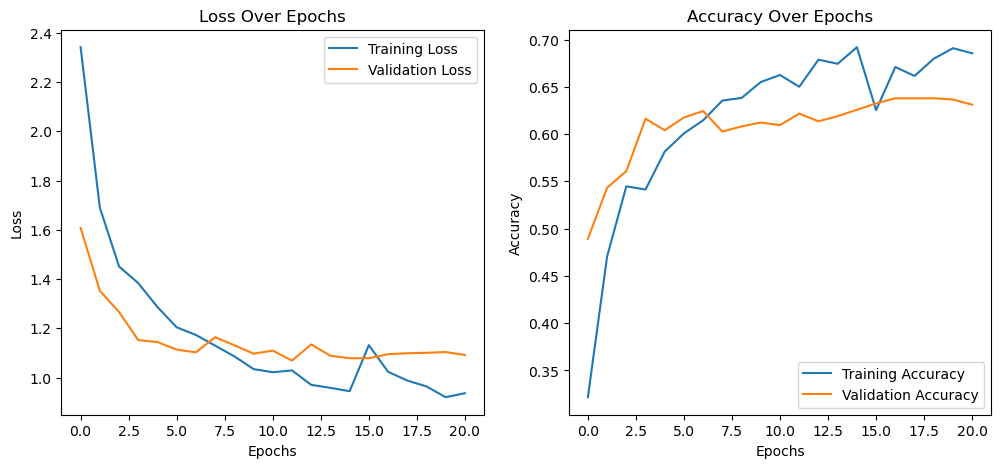

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define dataset directory
data_dir = r'C:\Users\Jarrel\Desktop\offrun'

# Set batch size and image size
batch_size = 32
img_size = (224, 224)

# Load dataset with an 80/20 split
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

raw_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Retrieve class names and number of classes
class_names = raw_train_dataset.class_names
num_classes = len(class_names)
print("Classes found:", class_names)

# Define data augmentation pipeline (Increased Augmentation)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),  # Increased rotation
    layers.RandomZoom(0.2),  # Increased zoom
    layers.RandomContrast(0.2)  # Increased contrast
])

# Define normalization layer
normalization_layer = layers.Rescaling(1.0/255)

# Apply augmentation and normalization to the training dataset
train_dataset = raw_train_dataset.map(
    lambda x, y: (normalization_layer(data_augmentation(x, training=True)), y)
)

# Apply normalization only to the validation dataset
val_dataset = raw_val_dataset.map(lambda x, y: (normalization_layer(x), y))

# Load the MobileNetV2 model with pretrained ImageNet weights (exclude the top layers)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Keep it frozen initially

# Create a model with the base MobileNetV2 and add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  # Increased neurons
    layers.Dropout(0.4),  # Increased dropout for regularization
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Initial learning rate
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Initial training (with frozen base model)
epochs_initial = 15  # Train initially for 10 epochs
history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_initial, callbacks=[early_stopping, model_checkpoint])

# Unfreeze top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-5]:  # Keep first layers frozen, unfreeze last 20
    layer.trainable = False

# Compile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Reduced learning rate for fine-tuning
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning training
epochs_finetune = 30  # Fine-tune for another 10 epochs
history_finetune = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_finetune, callbacks=[early_stopping, model_checkpoint])

# Plot Training Results
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'] + history_finetune.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_finetune.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()

# Save the final fine-tuned model
model.save('fine_tuned_clothing_model.h5')